In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np # linear algebra

!git clone https://github.com/mathbeveridge/gameofthrones
df = pd.read_csv('/content/gameofthrones/data/got-s1-edges.csv')

fatal: destination path 'gameofthrones' already exists and is not an empty directory.


In [2]:
df.head(3)

,Source,Target,Weight,Season
0,NED,ROBERT,192,1
1,DAENERYS,JORAH,154,1
2,JON,SAM,121,1


## Create Graph Database
* Reference: https://ericmjl.github.io/Network-Analysis-Made-Simple/05-casestudies/01-gameofthrones/#community-detection-in-networks

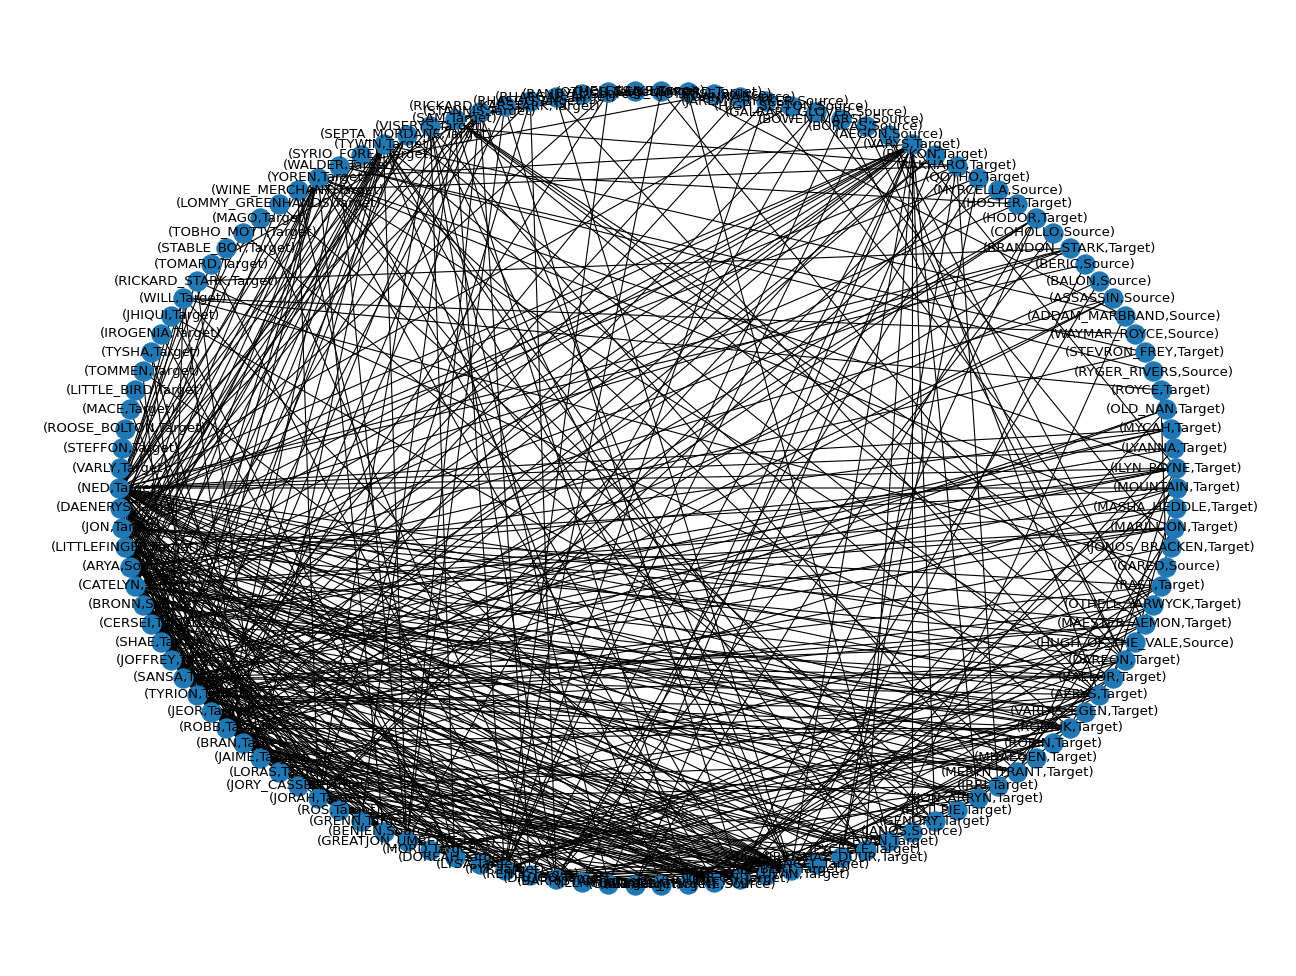

In [15]:

def get_G(data, edge_nodes):
    edge_list = []
    for edge in edge_nodes:
        edge_list += list(zip(data[edge[0]], data[edge[1]], data[edge[2]]))
    return(edge_list)

def create_simple_bipartite_graph(data, nodes, plot = True):
    BG = nx.Graph()
    node1 = list(data[nodes[0]].unique())
    node2 = list(data[nodes[1]].unique())
    
    BG.add_nodes_from(node1, bipartite=0, _type=nodes[0])
    BG.add_nodes_from(node2, bipartite=1, _type=nodes[1])

    edges = get_G(data, [nodes])
    BG.add_weighted_edges_from(edges)
    labels = dict((n, "(" + n + "," + d['_type'] + ")") for n,d in BG.nodes(data=True))

    u = [n for n in BG.nodes if BG.nodes[n]['bipartite'] == 0]
    X, Y = nx.bipartite.sets(BG, top_nodes=u)

    # X, Y = bipartite.sets(BG)
    pos = dict()
    pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
    
    plt.figure(figsize=(16, 12), dpi=80)
    edges = BG.edges()
    if plot == True:
    #     nx.draw_networkx(BG, pos, labels=labels)
    #     nx.draw(BG, pos, labels=labels)
    #     nx.draw(BG, pos=nx.circular_layout(BG), labels=labels)
        nx.draw(BG, pos=nx.shell_layout(BG), labels=labels)
    #     nx.draw(BG, pos=nx.random_layout(BG), labels=labels)
    return(BG)

    
testG = create_simple_bipartite_graph(df, ['Source','Target','Weight'])



## Community Detection

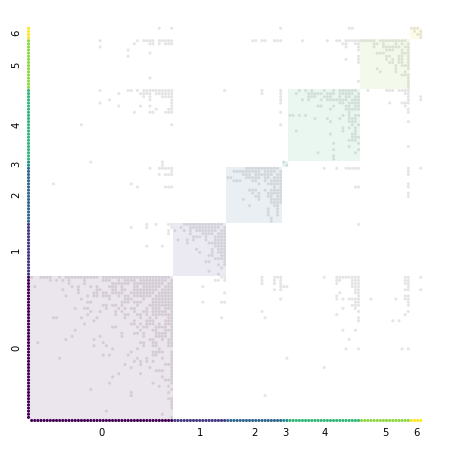

In [33]:
# !pip install nxviz
import community
import nxviz as nv
from nxviz import annotate
plt.figure(figsize=(8, 8))

partition = community.community_louvain.best_partition(testG, randomize=False)

# Annotate nodes' partitions
for n in testG.nodes():
    testG.nodes[n]["partition"] = partition[n]
    testG.nodes[n]["degree"] = testG.degree(n)

nv.matrix(testG, group_by="partition", sort_by="degree", node_color_by="partition")
annotate.matrix_block(testG, group_by="partition", color_by="partition")
annotate.matrix_group(testG, group_by="partition", offset=-8)


In [34]:
partition_dict = {}
for character, par in partition.items():
    if par in partition_dict:
        partition_dict[par].append(character)
    else:
        partition_dict[par] = [character]

len(partition_dict)

7

In [40]:
print(partition_dict[2],'\n', partition_dict[1])

['JON', 'JEOR', 'GRENN', 'BENJEN', 'PYP', 'ALLISER_THORNE', 'DAREON', 'MAESTER_AEMON', 'OTHELL_YARWYCK', 'RAST', 'BORCAS', 'BOWEN_MARSH', 'JAREMY_RYKKER', 'LUKE', 'MELESSA', 'OTHOR', 'RANDYLL', 'SAM'] 
 ['DAENERYS', 'JORAH', 'DOREAH', 'DROGO', 'ILLYRIO', 'MIRRI_MAZ_DUUR', 'IRRI', 'COHOLLO', 'QOTHO', 'RAKHARO', 'RHAEGO', 'VISERYS', 'WINE_MERCHANT', 'MAGO', 'JHIQUI', 'IROGENIA', 'LITTLE_BIRD']


In [41]:
def most_important_node_in_partition(graph, partition_dict):
    max_d = {}
    deg = nx.degree_centrality(graph)
    for group in partition_dict:
        temp = 0
        for character in partition_dict[group]:
            if deg[character] > temp:
                max_d[group] = character
                temp = deg[character]
    return max_d


most_important_node_in_partition(testG, partition_dict)    

{0: 'NED',
 1: 'DAENERYS',
 2: 'JON',
 3: 'HOT_PIE',
 4: 'CATELYN',
 5: 'TYRION',
 6: 'WILL'}

#### Community Plot
* https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

## Centrality

In [48]:
sorted(nx.degree_centrality(testG).items(),
       key=lambda x:x[1], reverse=True)[0:10]


[('NED', 0.456),
 ('TYRION', 0.328),
 ('CATELYN', 0.28800000000000003),
 ('ROBERT', 0.28800000000000003),
 ('ROBB', 0.24),
 ('CERSEI', 0.232),
 ('ARYA', 0.224),
 ('JOFFREY', 0.216),
 ('JON', 0.20800000000000002),
 ('LITTLEFINGER', 0.20800000000000002)]

In [49]:
sorted(nx.closeness_centrality(testG).items(),
       key=lambda x:x[1], reverse=True)[0:10]


[('NED', 0.628140703517588),
 ('ROBERT', 0.5530973451327433),
 ('CATELYN', 0.5506607929515418),
 ('TYRION', 0.5434782608695652),
 ('JON', 0.5186721991701245),
 ('ROBB', 0.5122950819672131),
 ('JOFFREY', 0.5102040816326531),
 ('CERSEI', 0.508130081300813),
 ('ARYA', 0.5020080321285141),
 ('JAIME', 0.49800796812749004)]

In [46]:
sorted(nx.betweenness_centrality(testG).items(),
       key=lambda x:x[1], reverse=True)[0:10]


[('NED', 0.30328020814787676),
 ('TYRION', 0.16302743524270866),
 ('CATELYN', 0.1182840529528203),
 ('ROBERT', 0.11039475684723857),
 ('DAENERYS', 0.10143128748178003),
 ('JON', 0.08533639644915648),
 ('ROBB', 0.08000074140585355),
 ('ARYA', 0.06600594833013682),
 ('PYP', 0.06091067421463663),
 ('JORAH', 0.05391044046587281)]